#0. Introdução

##0.1 Contexto

O CEO da Amazon contratou um time de cientistas de dados
para trabalhar em diferentes vertentes da empresa, e você
ficou encarregado de fazer um sistema de recomendação para
os clientes Amazon. Para isso, te deram acesso à uma base de
dados não muito estruturada em Json: um arquivo de
metadata com informações dos produtos e outro com as
avaliações.

##0.2 Projeto

* O CEO deseja que seu algoritmo de recomendação seja
exclusivamente em cima de avaliações verificadas (campo
`verified`=True no arquivo de avaliações). 
*Contudo, há uma base sem classificação e que o CEO faz questão de que seja
adicionada no sistema de recomendação (valores com missing
value na coluna `verified`). Para isso, será preciso classificar
se estas avaliações são verificadas ou não, e no caso positivo,
adicioná-los no sistema de recomendação.
* Adicionalmente, o CEO também deseja saber de possíveis
associações e/ou correlações nesta base de dados.
* Carregar, limpar e fazer análises exploratórias no banco de
dados fornecido;
* Classificar a base sem informação para incluir as observações
das avaliações verificadas no sistema de recomendação;
* Desenvolver e entregar um sistema de recomendação, com
exemplos de aplicação.

##0.3 Importando as Bibliotecas necessárias

In [1]:
# Bibliotecas Gerais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab              import drive

# Bibliotecas Classificação
from sklearn.model_selection       import train_test_split, GridSearchCV
from sklearn.model_selection       import RandomizedSearchCV
from sklearn                       import metrics
from sklearn.preprocessing         import MinMaxScaler
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.linear_model          import LogisticRegression
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.ensemble              import RandomForestClassifier
from sklearn.naive_bayes           import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.svm                   import SVC
from sklearn.neural_network        import MLPClassifier
from sklearn.metrics               import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics               import classification_report
from sklearn.metrics               import plot_confusion_matrix
from sklearn.metrics               import plot_roc_curve

# Bibliotecas de Recomendação
from sklearn.metrics.pairwise      import cosine_similarity

# Redução de Dimensionalidade
from sklearn.decomposition           import PCA
from sklearn.decomposition           import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

##0.4 Importando os Datasets

In [2]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
path = '/content/gdrive/MyDrive/Colab Notebooks/Bases/meta_Video_Games.json'
df1= pd.read_json(path,lines=True)
df01 = df1.copy()

In [4]:
path = '/content/gdrive/MyDrive/Colab Notebooks/Bases/Video_Games_sample.json'
df2= pd.read_json(path,lines=True)
df02 = df2.copy()

In [5]:
df01.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Video Games, PC, Games]",,[],,Reversi Sensory Challenger,[],,Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,,,0042000742,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,"[Video Games, Xbox 360, Games, </span></span><...",,[Brand new sealed!],,Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],,by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,,"\n\t\t\t\t\t\t\t\t\t\t\t\t<span class=""vertica...",0078764343,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,"[Video Games, Retro Gaming & Microconsoles, Su...",,[],,street fighter 2 II turbo super nintendo snes ...,[],,Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,,$0.72,0276425316,[],[],NaN
3,"[Video Games, Xbox 360, Accessories, Controlle...",,[MAS's Pro Xbox 360 Stick (Perfect 360 Stick) ...,,Xbox 360 MAS STICK,[],,by\n \n MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,,,0324411812,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
4,"[Video Games, PC, Games, </span></span></span>...",,"[Phonics Alive! 3, The Speller teaches student...",,Phonics Alive! 3: The Speller,[],,by\n \n Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,,,0439335310,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


In [6]:
df02.head()

,overall,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,verified,vote,image
0,1,"01 2, 2018",A16FEXIKAPT24U,B00000JRSB,{'Format:': ' Video Game'},Nicholas Sabin,Game disc was cracked thats pretty lame,Game disc 1 was cracked,1514851200,NaN,NaN,NaN
1,5,"01 2, 2018",A3ISBEPYLY8IMO,B00000JRSB,{'Format:': ' Video Game'},Jimmy,Received this in perfect condition. Great rese...,Received this in perfect condition. Great rese...,1514851200,1.0,NaN,NaN
2,5,"12 21, 2017",A1RIUB1PZWLOVZ,B00000JRSB,{'Format:': ' Video Game'},Amazon Customer,I had a hard time finding this game locally or...,I am very pleased with this purchase,1513814400,1.0,NaN,NaN
3,5,"12 20, 2017",A2VY0K54SOCG0F,B00000JRSB,{'Format:': ' Video Game'},Oscentatious,This game is just as amazing as the first time...,This is the best deal for this game,1513728000,0.0,NaN,NaN
4,5,"12 19, 2017",A1ABJQ2REV14OQ,B00000JRSB,{'Format:': ' Video Game'},Thiago,"I bought as a gift for my friend, she is so ex...",Loved by lots of people,1513641600,1.0,NaN,NaN


#1. Análise inicial dos dados

In [7]:
df = df01.merge(df02, on = ['asin'])

In [8]:
df.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details,overall,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,verified,vote,image
0,"[Video Games, Retro Gaming &amp; Microconsoles...",,[Long recognized as role-playing games par exc...,,Final Fantasy VII,"[B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...",,SquareSoft,"[1 Player, RPG, 3 Disc Set, Excellent graphics...","[>#5,076 in Video Games (See Top 100 in Video ...","[B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...",Video Games,,,$164.91,B00000JRSB,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{},1,"01 2, 2018",A16FEXIKAPT24U,{'Format:': ' Video Game'},Nicholas Sabin,Game disc was cracked thats pretty lame,Game disc 1 was cracked,1514851200,NaN,NaN,NaN
1,"[Video Games, Retro Gaming &amp; Microconsoles...",,[Long recognized as role-playing games par exc...,,Final Fantasy VII,"[B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...",,SquareSoft,"[1 Player, RPG, 3 Disc Set, Excellent graphics...","[>#5,076 in Video Games (See Top 100 in Video ...","[B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...",Video Games,,,$164.91,B00000JRSB,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{},5,"01 2, 2018",A3ISBEPYLY8IMO,{'Format:': ' Video Game'},Jimmy,Received this in perfect condition. Great rese...,Received this in perfect condition. Great rese...,1514851200,1.0,NaN,NaN
2,"[Video Games, Retro Gaming &amp; Microconsoles...",,[Long recognized as role-playing games par exc...,,Final Fantasy VII,"[B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...",,SquareSoft,"[1 Player, RPG, 3 Disc Set, Excellent graphics...","[>#5,076 in Video Games (See Top 100 in Video ...","[B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...",Video Games,,,$164.91,B00000JRSB,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{},5,"12 21, 2017",A1RIUB1PZWLOVZ,{'Format:': ' Video Game'},Amazon Customer,I had a hard time finding this game locally or...,I am very pleased with this purchase,1513814400,1.0,NaN,NaN
3,"[Video Games, Retro Gaming &amp; Microconsoles...",,[Long recognized as role-playing games par exc...,,Final Fantasy VII,"[B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...",,SquareSoft,"[1 Player, RPG, 3 Disc Set, Excellent graphics...","[>#5,076 in Video Games (See Top 100 in Video ...","[B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...",Video Games,,,$164.91,B00000JRSB,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{},5,"12 20, 2017",A2VY0K54SOCG0F,{'Format:': ' Video Game'},Oscentatious,This game is just as amazing as the first time...,This is the best deal for this game,1513728000,0.0,NaN,NaN
4,"[Video Games, Retro Gaming &amp; Microconsoles...",,[Long recognized as role-playing games par exc...,,Final Fantasy VII,"[B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...",,SquareSoft,"[1 Player, RPG, 3 Disc Set, Excellent graphics...","[>#5,076 in Video Games (See Top 100 in Video ...","[B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...",Video Games,,,$164.91,B00000JRSB,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{},5,"12 19, 2017",A1ABJQ2REV14OQ,{'Format:': ' Video Game'},Thiago,"I bought as a gift for my friend, she is so ex...",Loved by lots of people,1513641600,1.0,NaN,NaN


##1.1 Limpeza e organização dos dados

Aqui serão feitas conversões de features, remoção de caracteres indesejáveis

In [9]:
df['price'] = df['price'].str.replace('$','')
df['brand'] = df['brand'].str.replace('by\n\n','')
df['brand'] = df['brand'].str.replace(' ', '')
df['category'] = df['category'].astype('str')
df['category'] = df['category'].str.replace('[', '')
df['category'] = df['category'].str.replace(']', '')
df['category'] = df['category'].str.replace(' ', '')
df['category'] = df['category'].str.replace(';', '.')
df['category'] = df['category'].str.replace(',', '.')

Abaixo iremos extrair da coluna category até 5 textos que categorizam o produto

In [10]:
df['Cat1'] = df['category'].str.split('.').str[0]
df['Cat2'] = df['category'].str.split('.').str[1]
df['Cat3'] = df['category'].str.split('.').str[2]
df['Cat4'] = df['category'].str.split('.').str[3]
df['Cat5'] = df['category'].str.split('.').str[4]
df['category'] = df['category'].astype('category')
df['brand']    = df['brand'].astype('category')
df['Cat1']  = df['Cat1'].astype('category')
df['Cat2']  = df['Cat2'].astype('category')
df['Cat3']  = df['Cat3'].astype('category')
df['Cat4']  = df['Cat4'].astype('category')
df['Cat5']  = df['Cat5'].astype('category')

In [12]:
df['price'] = pd.to_numeric(df['price'], errors="coerce")

Abaixo segue uma verificação de nulos e a remoção de "image" e "vote" por ter vários valores nulos

In [14]:
pd.DataFrame(df.isnull().sum(axis=0)).sort_values(by=0, ascending=False)/df.shape[0]

,0
image,0.989856
vote,0.872242
price,0.713242
Cat5,0.585217
style,0.296429
verified,0.152242
Cat4,0.136260
Cat3,0.028065
reviewText,0.000750
summary,0.000365


In [15]:
df.drop(['image','vote'],axis=1,inplace=True)

##1.2 Distribuição das variáveis

Em seguida uma distribuição dos dados por categorias

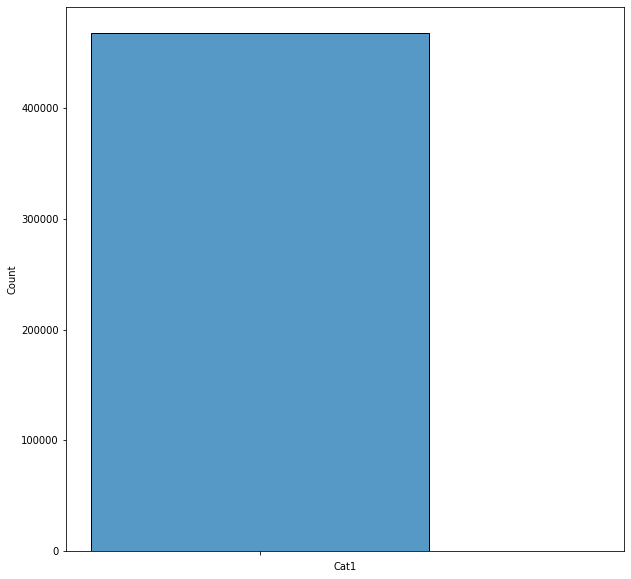

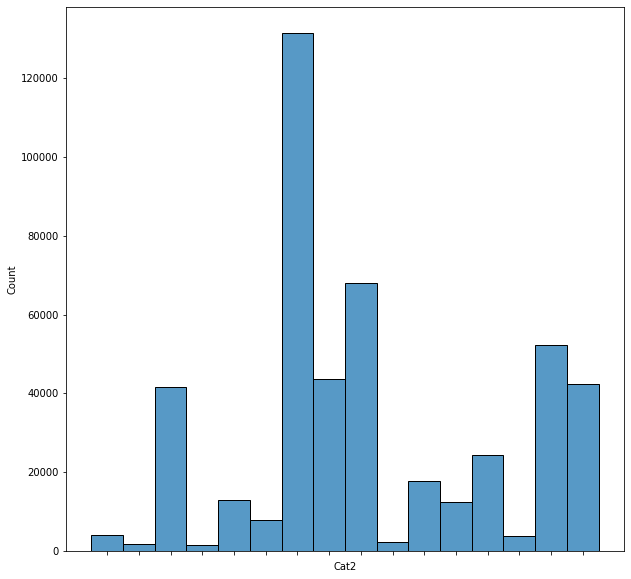

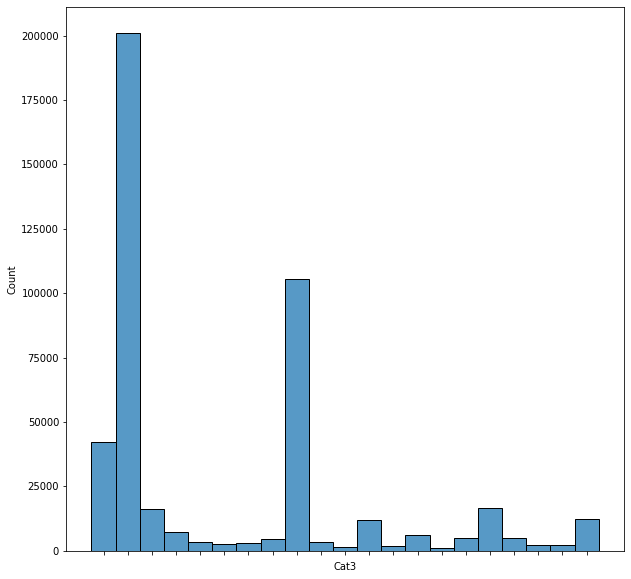

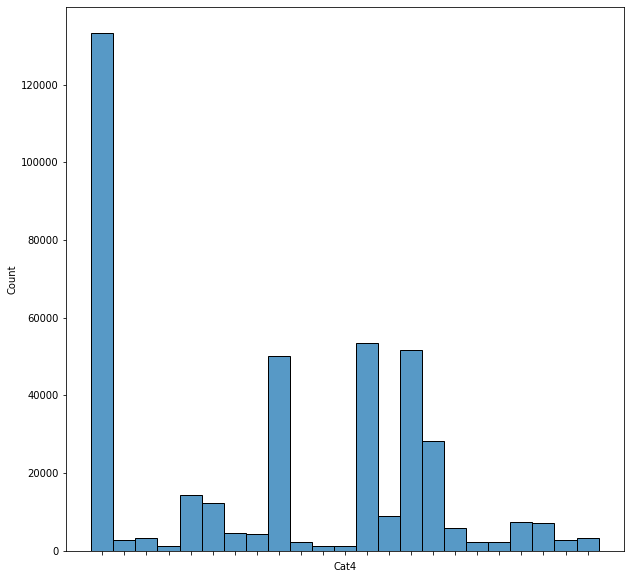

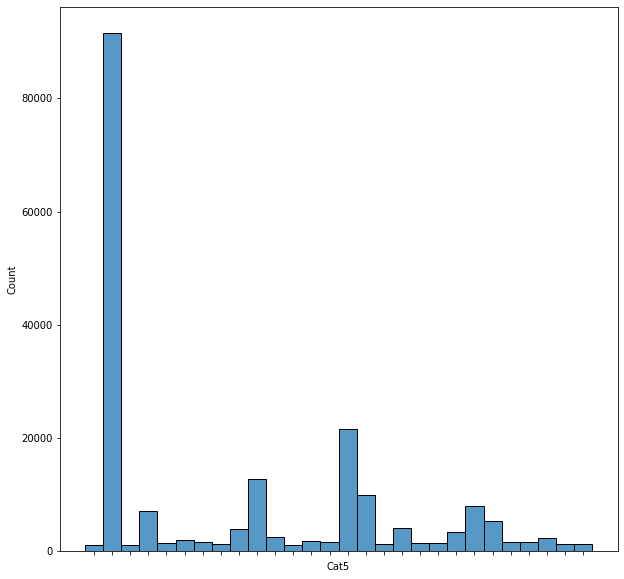

In [16]:
col = ['Cat1','Cat2','Cat3','Cat4','Cat5']
ncol = len(col)

for i in range(0,ncol):
  plt.figure(figsize=(10,10))
  fig = sns.histplot(x=col[i],data=df)
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
  plt.show()
  plt.close()

##1.3 Extração de Textos

Aqui será feito uma vetorização para extrair textos relevantes baseados nas reviews dos usuários para obter palavras chave e retornar uma matriz do tamanho de linhas do dataset e 50 componentes extraidos do texto. Vamos relacionar isso com a váriável "verified" para criar o modelo de classificação.

In [17]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=2000)
X_vectorizer = vectorizer.fit_transform(df['reviewText'].apply(lambda x: np.str_(x)))

In [18]:
n_components = 50
svd = TruncatedSVD(n_components=n_components)
X_red = svd.fit_transform(X_vectorizer)
df_cl = pd.DataFrame(X_red)

In [19]:
df_cl['target'] = df['verified']

In [20]:
df_fl = df_cl.copy()

In [21]:
df_fl.shape

(467980, 51)

Aqui vamos remover os nulos da coluna 'verified' para aplicação dos modelos, e após a obtenção dos melhores parâmetros, vamos retornar esses dados para não perdê-los

In [22]:
df_cl = df_cl.dropna()

In [23]:
df_cl.shape

(396734, 51)

#2. Modelo de Classificação

Abaixo vamos extrair uma amostra do dataset e aplicar uma separação de dados de treino para aplicar o modelo e dados de teste para avaliar o modelo

In [24]:
sample = 50000
df_sample = df_cl.sample(sample)

In [25]:
X  = df_sample.drop(columns=["target"])
y  = df_sample["target"]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape X_train: {X_train.shape}")
print(f"Shape y_train: {y_train.shape}")
print(f"Shape X_test: {X_test.shape}")
print(f"Shape y_test: {y_test.shape}")

Shape X_train: (40000, 50)
Shape y_train: (40000,)
Shape X_test: (10000, 50)
Shape y_test: (10000,)


In [27]:
scores_list = []
K_neighbors = range(1,15)

for k in K_neighbors:

  knn =  KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  scores_list.append(accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Acurácia')

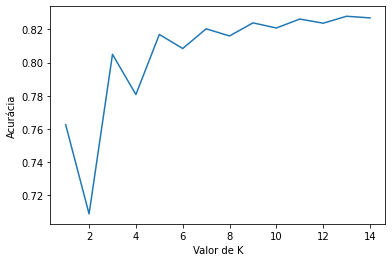

In [28]:
plt.plot(K_neighbors, scores_list)
plt.xlabel("Valor de K")
plt.ylabel("Acurácia")

Vamos utilizar diversos modelos de uma vez e listar aquele que tiver as melhores métricas de classificação (F1 Score, Precision, Accuracy, Recall)

In [29]:
models = {
    'KNN': KNeighborsClassifier(n_neighbors=11),
    'LogisticRegression': LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(criterion="entropy"),
    'RandomForestClassifier': RandomForestClassifier(criterion='entropy', n_estimators=100),
    'GaussianNB': GaussianNB(),
    'SVC_Poly': SVC(kernel='poly'),
    'SVC_Linear': SVC(kernel='linear'),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=(100, 50, 20),activation='relu')}

------------------------------------------------------------------
KNN
Acccuracy: 82.63%
Precision: 86.28%
Recall: 93.31%
F1: 89.65%
              precision    recall  f1-score   support

         0.0       0.58      0.38      0.46      1934
         1.0       0.86      0.93      0.90      8066

    accuracy                           0.83     10000
   macro avg       0.72      0.66      0.68     10000
weighted avg       0.81      0.83      0.81     10000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


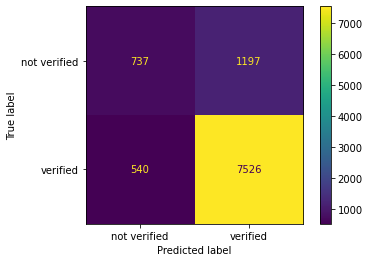

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


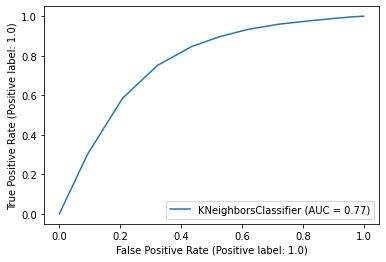

------------------------------------------------------------------
------------------------------------------------------------------
LogisticRegression
Acccuracy: 83.01%
Precision: 84.72%
Recall: 96.31%
F1: 90.14%
              precision    recall  f1-score   support

         0.0       0.64      0.28      0.39      1934
         1.0       0.85      0.96      0.90      8066

    accuracy                           0.83     10000
   macro avg       0.74      0.62      0.64     10000
weighted avg       0.81      0.83      0.80     10000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


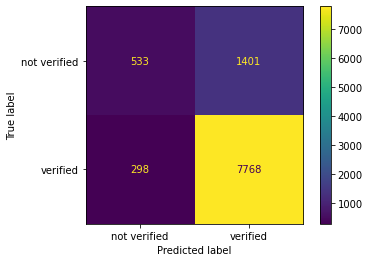

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


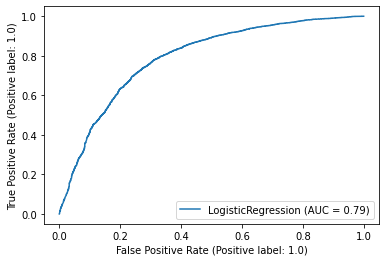

------------------------------------------------------------------
------------------------------------------------------------------
DecisionTreeClassifier
Acccuracy: 76.29%
Precision: 85.62%
Recall: 84.86%
F1: 85.24%
              precision    recall  f1-score   support

         0.0       0.39      0.41      0.40      1934
         1.0       0.86      0.85      0.85      8066

    accuracy                           0.76     10000
   macro avg       0.62      0.63      0.63     10000
weighted avg       0.77      0.76      0.76     10000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


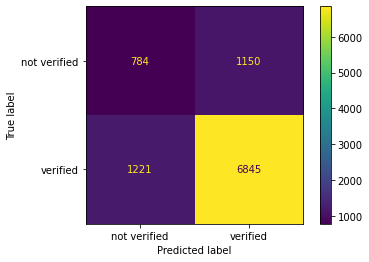

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


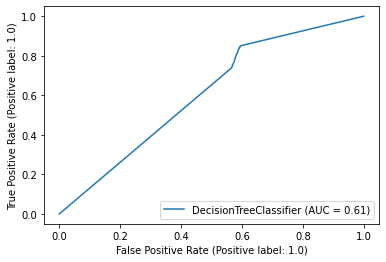

------------------------------------------------------------------
------------------------------------------------------------------
RandomForestClassifier
Acccuracy: 83.84%
Precision: 86.05%
Recall: 95.44%
F1: 90.5%
              precision    recall  f1-score   support

         0.0       0.65      0.35      0.46      1934
         1.0       0.86      0.95      0.91      8066

    accuracy                           0.84     10000
   macro avg       0.76      0.65      0.68     10000
weighted avg       0.82      0.84      0.82     10000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


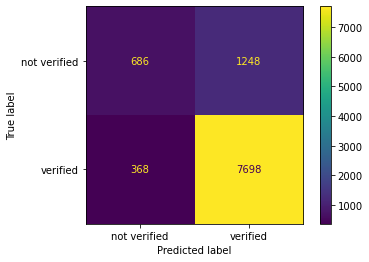

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


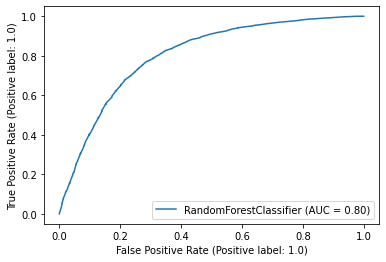

------------------------------------------------------------------
------------------------------------------------------------------
GaussianNB
Acccuracy: 55.53%
Precision: 91.19%
Recall: 49.67%
F1: 64.31%
              precision    recall  f1-score   support

         0.0       0.28      0.80      0.41      1934
         1.0       0.91      0.50      0.64      8066

    accuracy                           0.56     10000
   macro avg       0.59      0.65      0.53     10000
weighted avg       0.79      0.56      0.60     10000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


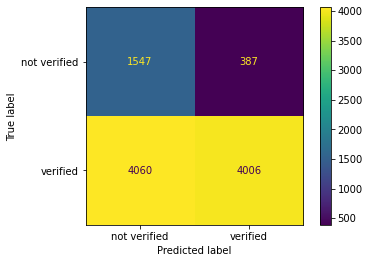

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


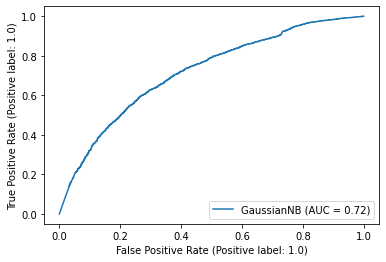

------------------------------------------------------------------
------------------------------------------------------------------
SVC_Poly
Acccuracy: 82.88%
Precision: 83.81%
Recall: 97.64%
F1: 90.2%
              precision    recall  f1-score   support

         0.0       0.68      0.21      0.32      1934
         1.0       0.84      0.98      0.90      8066

    accuracy                           0.83     10000
   macro avg       0.76      0.59      0.61     10000
weighted avg       0.81      0.83      0.79     10000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


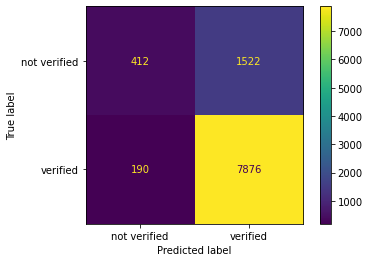

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


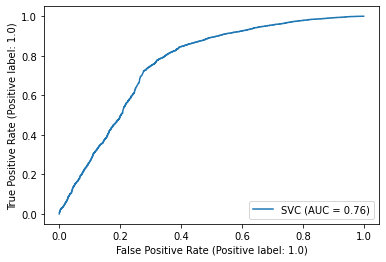

------------------------------------------------------------------
------------------------------------------------------------------
SVC_Linear
Acccuracy: 80.72%
Precision: 80.75%
Recall: 99.93%
F1: 89.32%
              precision    recall  f1-score   support

         0.0       0.67      0.01      0.01      1934
         1.0       0.81      1.00      0.89      8066

    accuracy                           0.81     10000
   macro avg       0.74      0.50      0.45     10000
weighted avg       0.78      0.81      0.72     10000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


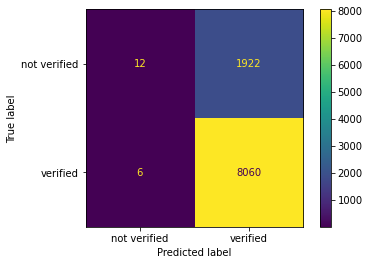

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


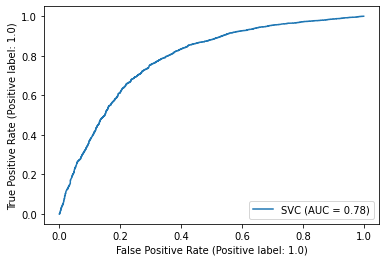

------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


------------------------------------------------------------------
MLPClassifier
Acccuracy: 81.04%
Precision: 85.96%
Recall: 91.42%
F1: 88.61%
              precision    recall  f1-score   support

         0.0       0.51      0.38      0.44      1934
         1.0       0.86      0.91      0.89      8066

    accuracy                           0.81     10000
   macro avg       0.69      0.65      0.66     10000
weighted avg       0.79      0.81      0.80     10000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


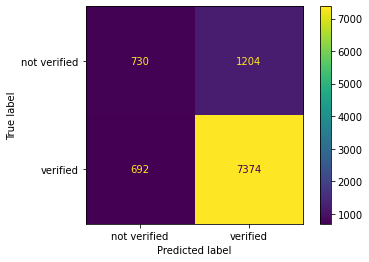

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


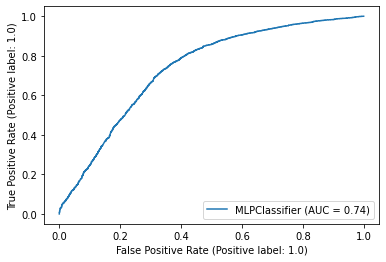

------------------------------------------------------------------


In [30]:
f1score_list    = []
accuracy_list   = []
recall_list     = []
precission_list = []
clf_list        = []

for name, model in models.items():

  clf = model
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)

  accuracy  = round(accuracy_score(y_test, y_pred)*100,ndigits=2)
  precision = round(precision_score(y_test, y_pred)*100,ndigits=2)
  recall    = round(recall_score(y_test, y_pred)*100,ndigits=2)
  f1score   = round(f1_score(y_test, y_pred)*100,ndigits=2)
  f1score_list.append(accuracy)
  accuracy_list.append(precision)
  recall_list.append(recall)
  precission_list.append(f1score)
  clf_list.append(name)

  print('------------------------------------------------------------------')
  print(name)
  print(f"Acccuracy: {accuracy}%")
  print(f"Precision: {precision}%")
  print(f"Recall: {recall}%")
  print(f"F1: {f1score}%")

  print(classification_report(y_test, y_pred))

  plot_confusion_matrix(clf, X_test, y_test, display_labels=['not verified','verified'], values_format='d')
  plt.grid(False)
  plt.show()

  plot_roc_curve(clf, X_test, y_test)
  plt.show()
  print('------------------------------------------------------------------')

In [31]:
df_metricas = pd.DataFrame({'Classificador': clf_list, 'F1-Score': f1score_list, 'Accuracy': accuracy_list, 'Recall': recall_list, 'Precission': precission_list})
df_metricas.sort_values(by='F1-Score', ascending=False)

,Classificador,F1-Score,Accuracy,Recall,Precission
3,RandomForestClassifier,83.84,86.05,95.44,90.50
1,LogisticRegression,83.01,84.72,96.31,90.14
5,SVC_Poly,82.88,83.81,97.64,90.20
0,KNN,82.63,86.28,93.31,89.65
7,MLPClassifier,81.04,85.96,91.42,88.61
6,SVC_Linear,80.72,80.75,99.93,89.32
2,DecisionTreeClassifier,76.29,85.62,84.86,85.24
4,GaussianNB,55.53,91.19,49.67,64.31


##2.1 Hiperparametrização

Pelo quadro acima o modelo RandomForestClassifier obteve um F1 Score maior que os demais, mas é possível aplicar uma hiperparametrização para aumentar esse valor

In [32]:
n_estimators = [100, 300, 600]
max_depth = [2, 4 , 8]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5]
hypam = dict(n_estimators = n_estimators, max_depth = max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf)

In [33]:
model = RandomForestClassifier()
rs = RandomizedSearchCV(model,hypam,cv = 3,verbose = 1,n_jobs = -1)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [2, 4, 8],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 300, 600]},
                   verbose=1)

In [34]:
rs.best_params_

{'max_depth': 8,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

Acccuracy: 82.9%
Precision: 84.26%
Recall: 96.9%
F1: 90.14%
              precision    recall  f1-score   support

         0.0       0.65      0.25      0.36      1934
         1.0       0.84      0.97      0.90      8066

    accuracy                           0.83     10000
   macro avg       0.75      0.61      0.63     10000
weighted avg       0.81      0.83      0.80     10000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


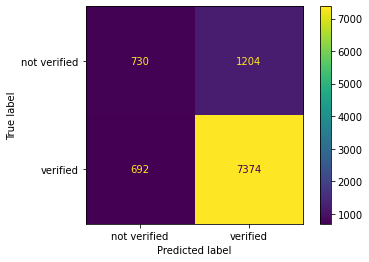

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


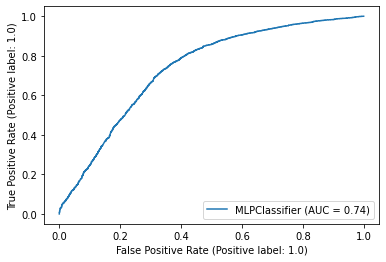

In [35]:
best = rs.best_estimator_
best.fit(X_train,y_train)
y_pred = best.predict(X_test)
f1score = round(np.mean(f1_score(y_test, y_pred,average=None))*100,ndigits=2)
accuracy = round(accuracy_score(y_test, y_pred)*100,ndigits=2)
precision = round(precision_score(y_test, y_pred)*100,ndigits=2)
recall = round(recall_score(y_test, y_pred)*100,ndigits=2)
f1score = round(f1_score(y_test, y_pred)*100,ndigits=2)

print(f"Acccuracy: {accuracy}%")
print(f"Precision: {precision}%")
print(f"Recall: {recall}%")
print(f"F1: {f1score}%")

print(classification_report(y_test, y_pred))

plot_confusion_matrix(clf, X_test, y_test, display_labels=['not verified','verified'], values_format='d')
plt.grid(False)
plt.show()

plot_roc_curve(clf, X_test, y_test)
plt.show()

##2.2 Testando toda a base de dados

Vamos aplicar o melhor estimador para toda a base de dados, os dados faltantes de 'verified' serão substituídos por 0

In [62]:
df_fl.shape

(467980, 52)

Shape X_train: (374384, 50)
Shape y_train: (374384,)
Shape X_test: (93596, 50)
Shape y_test: (93596,)
------------------------------------------------------------------
Acccuracy: 72.63%
Precision: 73.4%
Recall: 94.02%
F1: 82.44%
              precision    recall  f1-score   support

         0.0       0.67      0.26      0.38     29636
         1.0       0.73      0.94      0.82     63960

    accuracy                           0.73     93596
   macro avg       0.70      0.60      0.60     93596
weighted avg       0.71      0.73      0.68     93596



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


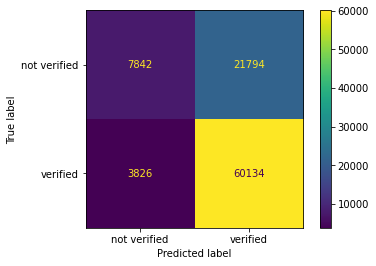

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


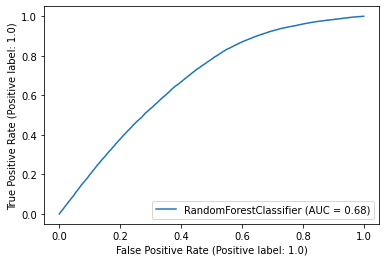

In [37]:
df_full = df_fl.copy()
df_full = df_full.fillna(0)

X  = df_full.drop(columns=["target"])
y  = df_full["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape X_train: {X_train.shape}")
print(f"Shape y_train: {y_train.shape}")
print(f"Shape X_test: {X_test.shape}")
print(f"Shape y_test: {y_test.shape}")

clf = rs.best_estimator_
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

f1score = round(np.mean(f1_score(y_test, y_pred,average=None))*100,ndigits=2)
accuracy = round(accuracy_score(y_test, y_pred)*100,ndigits=2)
precision = round(precision_score(y_test, y_pred)*100,ndigits=2)
recall = round(recall_score(y_test, y_pred)*100,ndigits=2)
f1score = round(f1_score(y_test, y_pred)*100,ndigits=2)

print('------------------------------------------------------------------')
print(f"Acccuracy: {accuracy}%")
print(f"Precision: {precision}%")
print(f"Recall: {recall}%")
print(f"F1: {f1score}%")

print(classification_report(y_test, y_pred))

plot_confusion_matrix(clf, X_test, y_test, display_labels=['not verified','verified'], values_format='d')
plt.grid(False)
plt.show()

plot_roc_curve(clf, X_test, y_test)
plt.show()

Com a adição de toda a base de dados, houve uma queda do F1 Score para 82,44%, mas ainda é um modelo com boa precisão.

#3. Modelo de recomendação

Abaixo será criado um modelo de recomendação simples baseado na soma de verificações dos usuários, num estilo de itens populares. Isso será feito juntando a base de ""verified" da avaliação e "asin" que é o ID do item.

In [39]:
X = df_full.drop(columns=["target"])
y_pred   = clf.predict(X)
df_fl['class'] = y_pred

In [43]:
df_rec = df[['asin','verified']].fillna(0)

In [44]:
df_rec.shape

(467980, 2)

In [45]:
df_rec['class'] = y_pred

In [46]:
df_rec.drop('verified',axis=1, inplace=True)

In [47]:
df_rec.sample(5)

,asin,class
86357,B00140P9BA,1.0
414157,B00Y8CQCXA,1.0
374330,B00MNP9PD8,1.0
390481,B00NW6T6CC,1.0
309898,B00GMFKYK8,1.0


In [55]:
df_sum = df_rec.groupby(by=['asin'], dropna=False,as_index=False).sum()

In [56]:
df_sum.columns = ['Produto','Total de Avaliações']

In [57]:
df_sum['Total de Avaliações'] = df_sum['Total de Avaliações'].astype('int')

In [58]:
df_sum.sample(5)

,Produto,Total de Avaliações
83,B0050SVNZ8,1334
38,B0011E4J2Y,1292
64,B002BSA3EM,1801
170,B00FWK8UWI,1970
46,B00166N6SA,1421


In [59]:
import random
vet_prod  = df_sum['Produto'].unique()
prod_id   =  random.randint(0,vet_prod.shape[0])
prod_name = vet_prod[prod_id]

In [63]:
mask = df_sum['Produto'] == prod_name
df_result = df_sum[mask]

if(df_result.shape[0]>0):

  display(df_result)

else:

  display(df_sum.sort_values(by='Total de Avaliações', ascending=False).head(10))

,Produto,Total de Avaliações
31,B000XGJH1O,1034


Caso o produto não esteja na base de dados, ele retorna o top 10 itens mais populares

In [61]:
mask = df_sum['Produto'] == 'ID Inexistente'
df_result = df_sum[mask]

if(df_result.shape[0]>0):

  display(df_result)

else:

  display(df_sum.sort_values(by='Total de Avaliações', ascending=False).head(10))

,Produto,Total de Avaliações
176,B00HTK1NCS,6461
80,B004RMK57U,5122
191,B00KKAQYXM,4359
9,B00009OY9U,4004
184,B00JJNQG98,3959
74,B003ZSP0WW,3953
156,B00E4MQODC,3520
12,B000B9RI14,3333
149,B00DBDPOZ4,3161
28,B000VJRU44,3142
